In [1]:
from get_sinks import get_sinks_from_content
import pandas as pd
import numpy as np
from extract_sink_features import sink_predict_class, SINK_TYPE_DICT

# 从CSV中导入数据

In [2]:
df = pd.read_csv('clean_datasets.csv')
print(df.columns)

Index(['file', 'code', 'vld', 'opcode', 'filter', 'label'], dtype='object')


In [3]:
opcode_list = df['opcode'].tolist()
code_list = df['code'].tolist()
filter_list = df['filter']
label_list = np.array(df['label'].tolist())
sink_type_list = []
for code in code_list:
    sink_type_list.append(get_sinks_from_content(code)[0])
sink_type_list = np.array(sink_type_list)

print(len(code_list))
print(len(sink_type_list))

10080
10080


## 替换

In [4]:
# 替换SINK、ENCAPSED STRING

opcode_clean_list = []
for i in range(len(opcode_list)):
    opcode = str(opcode_list[i]).split(' ')
    for j in range(len(opcode)-1, -1, -1):
        if opcode[j] == 'ECHO':
            opcode[j] = SINK_TYPE_DICT[sink_predict_class(sink_type_list[i])]
            break

    opcode_clean_list.append(' '.join(opcode))
print(len(opcode_clean_list))

10080


In [5]:
# 替换FUNCTION

for element in enumerate(zip(opcode_clean_list, filter_list)):
    index = element[0]    # Index of enumeration
    opcode_filter_tup = element[1]    # (opcode_sequence, filters)
    opcode = opcode_filter_tup[0].split(' ')    # to list
    filters = opcode_filter_tup[1].split(' ')    # to list
    count_init = 0
    count_do = 0
    # 无filter：
    if 'NO_FILTER' in filters:
        opcode_clean_list[index] = ' '.join(opcode)
        continue    # 跳转到下一份opcode序列
    # 有filter：
    for i in range(len(opcode)):    # 替换INIT_FCALL
        if opcode[i] == 'INIT_FCALL':
            opcode[i] = str(filters[count_init])
            count_init += 1
#         if opcode[i] == 'DO_ICALL' and count_init != 0:    # 执行INIT_FCALL的地方必须在INIT_FCALL之后
#             opcode[i] = 'DO_' + str(filters[count_do])
#             count_do += 1
    opcode_clean_list[index] = ' '.join(opcode)


## 直接append

In [ ]:
for i in range(len(opcode_list)):
    opcode_list[i] = opcode_list[i] + ' ' + filter_list[i]
    opcode_list[i] = opcode_list[i] + ' ' + SINK_TYPE_DICT[sink_predict_class(sink_type_list[i])]
#     opcode_list[i] = opcode_list[i].split(' ')


# Test

In [6]:
index = 9
print('>>> Filters: ')
print(filter_list[index] + '\n')
print('>>> Normal: ')
print(opcode_list[index] + '\n')
print('>>> Clean: ')
print(opcode_clean_list[index] + '\n')
# print(code_list[index] + '\n')
print(len(opcode_clean_list))

>>> Filters: 
FILTER_VAR

>>> Normal: 
ECHO NEW DO_FCALL ASSIGN INIT_METHOD_CALL DO_FCALL ASSIGN INIT_FCALL SEND_VAR SEND_VAL DO_ICALL ASSIGN ASSIGN CONCAT CONCAT ECHO ECHO RETURN FETCH_OBJ_R FETCH_DIM_R RETURN RETURN ASSIGN_OBJ OP_DATA FETCH_OBJ_W ASSIGN_DIM OP_DATA FETCH_R FETCH_DIM_R FETCH_OBJ_W ASSIGN_DIM OP_DATA FETCH_OBJ_W ASSIGN_DIM OP_DATA RETURN

>>> Clean: 
ECHO NEW DO_FCALL ASSIGN INIT_METHOD_CALL DO_FCALL ASSIGN FILTER_VAR SEND_VAR SEND_VAL DO_ICALL ASSIGN ASSIGN CONCAT CONCAT ECHO ECHO_SINK_SINGLE_QUOTE_JS_BLOCK RETURN FETCH_OBJ_R FETCH_DIM_R RETURN RETURN ASSIGN_OBJ OP_DATA FETCH_OBJ_W ASSIGN_DIM OP_DATA FETCH_R FETCH_DIM_R FETCH_OBJ_W ASSIGN_DIM OP_DATA FETCH_OBJ_W ASSIGN_DIM OP_DATA RETURN

10080


# TF-IDF 模型

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# CV = CountVectorizer(ngram_range=(5,5), decode_error='ignore',
#                     token_pattern=r'\b\w+\b', min_df=1, max_df=1.0)
# X = CV.fit_transform(opcode_list).toarray()
# # print(X[:2])
# Tfid = TfidfTransformer(smooth_idf=False)
# tfidf_value = Tfid.fit_transform(X)
# # print(tfidf_value)
# X_tfid = np.array(tfidf_value.toarray())
# print(X_tfid.shape)

tfidf = TfidfVectorizer()
re = tfidf.fit_transform(opcode_clean_list)
# print(re)
X_tfid = np.array(re.toarray())
print(X_tfid.shape)

(10080, 66)


# SVM

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X_tfid, label_list, random_state=2019, test_size = 0.3, stratify=label_list)

# 标准化
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train).astype('float32')
X_test_std = std_scaler.transform(X_test).astype('float32')

print(X_train_std.shape)
print(X_test_std.shape)

(7056, 66)
(3024, 66)


In [9]:
from sklearn import svm
# from sklearn.ensemble import RandomForestClassifier

svc = svm.SVC(kernel='linear', C=1.0, gamma='auto', probability=True, random_state=2019)  # 线性核

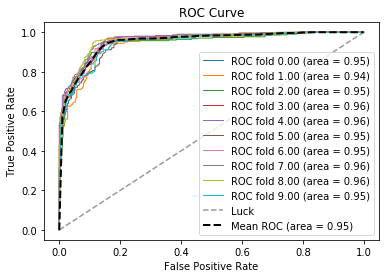

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

cv = StratifiedKFold(n_splits=10)    #导入该模型，后面将数据划分10份
 
# 画平均ROC曲线的两个参数
mean_tpr = 0.0              # 用来记录画平均ROC曲线的信息
mean_fpr = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)
cnt = 0
for i, (train, test) in enumerate(cv.split(X_train_std,y_train)):       #利用模型划分数据集和目标变量 为一一对应的下标
    cnt +=1
    probas_ = svc.fit(X_train_std[train], y_train[train]).predict_proba(X_train_std[test]) # 训练模型后预测每条样本得到两种结果的概率
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])    # 该函数得到伪正例、真正例、阈值，这里只使用前两个
 
    mean_tpr += np.interp(mean_fpr, fpr, tpr)   # 插值函数 interp(x坐标,每次x增加距离,y坐标)  累计每次循环的总值后面求平均值
    mean_tpr[0] = 0.0           # 将第一个真正例=0 以0为起点
 
    roc_auc = auc(fpr, tpr)  # 求auc面积
    plt.plot(fpr, tpr, lw=1, label='ROC fold {0:.2f} (area = {1:.2f})'.format(i, roc_auc))    # 画出当前分割数据的ROC曲线

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck') # 画对角线
 
mean_tpr /= cnt   # 求数组的平均值
mean_tpr[-1] = 1.0   # 坐标最后一个点为（1,1）  以1为终点
mean_auc = auc(mean_fpr, mean_tpr)
 
plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = {0:.2f})'.format(mean_auc), lw=2)
 
plt.xlim([-0.05, 1.05])     # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
from sklearn import metrics
predict_target = svc.predict(X_test_std)
print(metrics.classification_report(y_test, predict_target, 
                                    target_names=['Good sanitize', 'Bad sanitize']))

               precision    recall  f1-score   support

Good sanitize       0.94      0.87      0.91      1718
 Bad sanitize       0.85      0.92      0.88      1306

     accuracy                           0.90      3024
    macro avg       0.89      0.90      0.90      3024
 weighted avg       0.90      0.90      0.90      3024



Text(0.5, 0, 'True label')

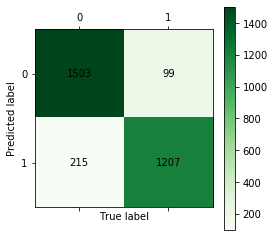

In [12]:
# Confusion matrix
%matplotlib inline

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, svc.predict(X_test_std))
plt.matshow(cm,cmap=plt.cm.Greens)
plt.colorbar()
for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(cm[x,y],xy=(x,y),horizontalalignment='center',verticalalignment='center')

plt.ylabel('Predicted label')# 坐标轴标签
plt.xlabel('True label')# 坐标轴标签

# Bi-LSTM

In [13]:
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_tfid, label_list, 
                                                    random_state=2019, test_size = 0.3, stratify=label_list)
y_train_init = y_train
y_train = to_categorical(y_train, 2).astype('int')
# y_test = to_categorical(y_test, 2).astype('int')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train).astype('float32').reshape(-1, X_train.shape[1], 1)
X_test_std = scaler.fit_transform(X_test).astype('float32').reshape(-1, X_test.shape[1], 1)

# 新模型

In [22]:
model = Sequential()
# model.add(Embedding(X_train.shape[0], 100, input_length=100))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='nadam',
             metrics=['acc'])

In [23]:
print(X_train_std.shape)
print(y_train.shape)
print(X_test_std.shape)
print(y_test.shape)

(7056, 66, 1)
(7056, 2)
(3024, 66, 1)
(3024,)


# 导入模型

In [18]:
from tensorflow.keras.models import load_model
model = load_model('./d2v_lstm_models/replace_128_neuron_bilstm_high_recall.h5')

# 训练

In [45]:
epoch_num = 1
history1 = model.fit(X_train_std, y_train, epochs=epoch_num, validation_split=0.2)

Train on 5644 samples, validate on 1412 samples
5644/5644 [==============================] - 28s 5ms/sample - loss: 0.1855 - acc: 0.8999 - val_loss: 0.2310 - val_acc: 0.8824


In [26]:
# 保存模型相关参数及训练中指标
model_name = 'tfidf_89_neuron_128_epoch_' + str(epoch_num)
# model.save('./d2v_lstm_models/' + model_name + '.h5')

accy=np.array(history1.history['acc'])
val_accy=np.array(history1.history['val_acc'])
lossy = np.array(history1.history['loss'])
val_lossy = np.array(history1.history['val_loss'])

acc_loss_df = pd.DataFrame(
    {'accuracy': accy,
     'validation_accuracy': val_accy,
     'loss': lossy,
     'validation_loss': val_lossy
    }
)
# acc_loss_df.to_excel('./accuracy_loss_related/' + model_name + '.xls', index=False)

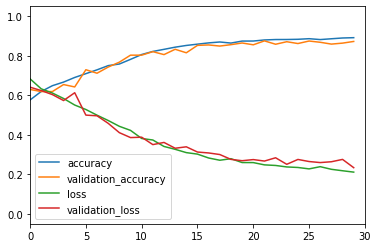

In [27]:
# metrics
# 1. Accuracy- loss
import matplotlib.pyplot as plt
plt.xlim(0, epoch_num)
plt.ylim([-0.05, 1.05])
plt.plot(range(epoch_num), accy, label='accuracy')
plt.plot(range(epoch_num), val_accy, label='validation_accuracy')
plt.plot(range(epoch_num), lossy, label='loss')
plt.plot(range(epoch_num), val_lossy, label='validation_loss')
plt.legend()
# plt.figure(figsize=(10,10.5))
plt.show()

Train on 7711 samples
7711/7711 [==============================] - 35s 5ms/sample - loss: 0.1653 - acc: 0.9049
Train on 7711 samples
7711/7711 [==============================] - 37s 5ms/sample - loss: 0.1776 - acc: 0.8985
Train on 7711 samples
7711/7711 [==============================] - 34s 4ms/sample - loss: 0.1951 - acc: 0.8987
Train on 7711 samples
7711/7711 [==============================] - 34s 4ms/sample - loss: 0.1708 - acc: 0.8998
Train on 7711 samples
7711/7711 [==============================] - 34s 4ms/sample - loss: 0.1696 - acc: 0.8992
Train on 7711 samples
7711/7711 [==============================] - 34s 4ms/sample - loss: 0.1656 - acc: 0.9065
Train on 7711 samples
7711/7711 [==============================] - 34s 4ms/sample - loss: 0.1675 - acc: 0.9038
Train on 7711 samples
7711/7711 [==============================] - 34s 4ms/sample - loss: 0.1711 - acc: 0.9011
Train on 7712 samples
7712/7712 [==============================] - 34s 4ms/sample - loss: 0.1670 - acc: 0.9034
T

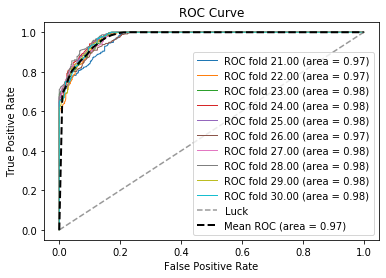

In [23]:
#定义n折交叉验证
from sklearn.model_selection import KFold
KF = KFold(n_splits=10)

from sklearn.metrics import roc_curve, auc
mean_tpr = 0.0              # 用来记录画平均ROC曲线的信息
mean_fpr = np.linspace(0, 1, 100)
cnt = 0
#data为数据集,利用KF.split划分训练集和测试集
for train_index,test_index in KF.split(X_train_std):
    cnt += 1
    #建立模型，并对训练集进行测试，求出预测得分
    #划分训练集和测试集
    X_train_kf, X_test_kf = X_train_std[train_index], X_train_std[test_index]
    Y_train_kf, Y_test_kf = y_train[train_index], y_train[test_index]
    #训练模型
    model.fit(X_train_kf, Y_train_kf, epochs=1)
    #利用model.predict获取测试集的预测值
    Y_pred_kf = model.predict(X_test_kf, batch_size=1)
    #计算fpr(假阳性率),tpr(真阳性率),thresholds(阈值)[绘制ROC曲线要用到这几个值]
    fpr, tpr, thresholds = roc_curve(Y_test_kf[:,1],Y_pred_kf[:,1])
    mean_tpr += np.interp(mean_fpr, fpr, tpr)   # 插值函数 interp(x坐标,每次x增加距离,y坐标)  累计每次循环的总值后面求平均值
    mean_tpr[0] = 0.0           # 将第一个真正例=0 以0为起点
 
    roc_auc = auc(fpr, tpr)  # 求auc面积
    plt.plot(fpr, tpr, lw=1, label='ROC fold {0:.2f} (area = {1:.2f})'.format(i, roc_auc))    # 画出当前分割数据的ROC曲线
    i += 1

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck') # 画对角线
mean_tpr /= cnt   # 求数组的平均值
mean_tpr[-1] = 1.0   # 坐标最后一个点为（1,1）  以1为终点
mean_auc = auc(mean_fpr, mean_tpr)
 
plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = {0:.2f})'.format(mean_auc), lw=2)
 
plt.xlim([-0.05, 1.05])     # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model_name = 'kf_10_tfidf_89_neuron_128_epoch_' + '200'
model.save('./d2v_lstm_models/' + model_name + '.h5')

In [46]:
from sklearn import metrics
predict_target = model.predict_classes(X_test_std)
# print(predict_target)
print(metrics.classification_report(y_test, predict_target, 
                                    target_names=['Good sanitize', 'Bad sanitize']))

               precision    recall  f1-score   support

Good sanitize       0.92      0.87      0.89      1718
 Bad sanitize       0.84      0.90      0.87      1306

     accuracy                           0.88      3024
    macro avg       0.88      0.88      0.88      3024
 weighted avg       0.89      0.88      0.88      3024



In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
predict_target = model.predict_classes(X_test_std)
print(accuracy_score(y_test, predict_target))
print(precision_score(y_test, predict_target))
print(recall_score(y_test, predict_target))

0.8832671957671958
0.8425593098490295
0.8973966309341501


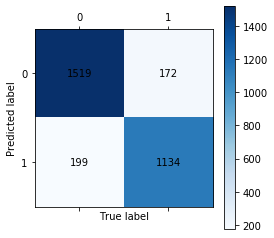

In [44]:
# 4.混淆矩阵
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model.predict_classes(X_test_std))
plt.matshow(cm,cmap=plt.cm.Blues)
plt.colorbar()
for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(cm[x,y],xy=(x,y),horizontalalignment='center',verticalalignment='center')

plt.ylabel('Predicted label')# 坐标轴标签
plt.xlabel('True label')# 坐标轴标签
plt.show()

# 确定是否需要保存？

# 切勿覆盖原有模型，请再次执行确认！

In [ ]:
# model.save('./d2v_lstm_models/append_64_neuron_bilstm.h5')
# model.save('./d2v_lstm_models/replace_100_neuron_bilstm.h5')
# model.save('./d2v_lstm_models/replace_128_neuron_bilstm_high_recall.h5')